In [1]:
import warnings
from configparser import ConfigParser

from easydict import EasyDict
from pytorch_lightning import seed_everything

from models.protoconv.comet_connector import CometConnector
from models.protoconv.data_visualizer import DataVisualizer
from utils import plot_html

warnings.simplefilter("ignore")
seed_everything(0)

config = ConfigParser()
config.read('../config.ini')
comet_config = EasyDict(config['cometml'])

comet_connector = CometConnector(comet_config.apikey, comet_config.projectname, comet_config.workspace, rel_path='..')


Global seed set to 0


In [2]:
experiments = {
    'imdb': 'abc1851dba1c46f28e16ddd90ec9c3e6',
    'amazon': 'e81f6bb0081f459c8e5c2b42cae6a2ea',
    'yelp': '26daecaeebd246a9ac9c14bdbafcc1fe',
    'rottentomatoes': '6b4aef88e5144aa396f4eef98490e3a7',
    'hotel': '9378a9ae08c64f96a2e6fabcdc33fa3c'
}

In [3]:

import torch
import pandas as pd
from more_itertools import powerset

for dataset, experiment_id in experiments.items():
    if dataset != 'hotel':
        continue

    for fold_id in range(5):
        plot_html(f'<h1>{dataset} {fold_id}</h1>')

        prototypes_words = []

        comet_connector.set_experiment(experiment_id, fold=fold_id)
        comet_connector.get_model()

        model = comet_connector.model
        model.cuda()
        model.eval()
        model.conv1.conv1.padding = 0

        data_visualizer = DataVisualizer(model)

        words_matrix = model.prototype_tokens.tolist()
        prototypes_id_tokens_to_extend = []

        stoi = comet_connector.TEXT.vocab.stoi
        itos = comet_connector.TEXT.vocab.itos

        plot_string = ''
        for proto_id, tokens_list in enumerate(words_matrix):
            if proto_id < 2:
                continue
            if model.enabled_prototypes_mask[proto_id].tolist() == 0:
                continue
            plot_data = []

            print(tokens_list)
            with torch.no_grad():
                x = torch.tensor(tokens_list).unsqueeze(0).cuda()
                embedding = model.embedding(x).permute((0, 2, 1))
                latent_space = model.conv1(embedding).squeeze(2).squeeze(0)

                for indexes_to_hide in powerset([0,1,2,3,4]):
                    if len(indexes_to_hide)>=5:
                        continue
                    new_x = [stoi['<unk>'] if token_id in indexes_to_hide else token
                             for token_id, token in enumerate(tokens_list)]
                    new_x_torch = torch.tensor(new_x).unsqueeze(0).cuda()
                    new_phrase = ' '.join(str(itos[t]) for t in new_x if t!=0)
                    embedding = model.embedding(new_x_torch).permute((0, 2, 1))
                    new_latent_space = model.conv1(embedding).squeeze(2).squeeze(0)
                    dist = torch.cdist(latent_space.unsqueeze(0), new_latent_space.unsqueeze(0)).tolist()
                    print(indexes_to_hide, dist, new_phrase)
                    plot_data.append([new_phrase, dist[0][0]])
            df = pd.DataFrame(plot_data, columns=['Phrase','Distance'])


            words = [itos[int(token)] for token in tokens_list]
            words = [w for w in words if w not in ['<START>', '<END>', '<pad>']]

            plot_string += ' '.join(words) + '<br>'
            break
        plot_html(plot_string)
        break

[125, 69, 208, 294, 486]
() [[0.0]] got an excellent rate thanks
(0,) [[0.847309947013855]] an excellent rate thanks
(1,) [[1.2396495342254639]] got excellent rate thanks
(2,) [[1.0120694637298584]] got an rate thanks
(3,) [[1.1226856708526611]] got an excellent thanks
(4,) [[1.6330969333648682]] got an excellent rate
(0, 1) [[2.0491092205047607]] excellent rate thanks
(0, 2) [[1.610662579536438]] an rate thanks
(0, 3) [[1.8494173288345337]] an excellent thanks
(0, 4) [[2.4542572498321533]] an excellent rate
(1, 2) [[1.855340600013733]] got rate thanks
(1, 3) [[2.165269136428833]] got excellent thanks
(1, 4) [[2.7956371307373047]] got excellent rate
(2, 3) [[1.5488430261611938]] got an thanks
(2, 4) [[2.3918638229370117]] got an rate
(3, 4) [[2.5191071033477783]] got an excellent
(0, 1, 2) [[2.626941442489624]] rate thanks
(0, 1, 3) [[2.7730395793914795]] excellent thanks
(0, 1, 4) [[3.313727378845215]] excellent rate
(0, 2, 3) [[2.3802027702331543]] an thanks
(0, 2, 4) [[2.93334627151

In [10]:
df = df.sort_values('Distance')


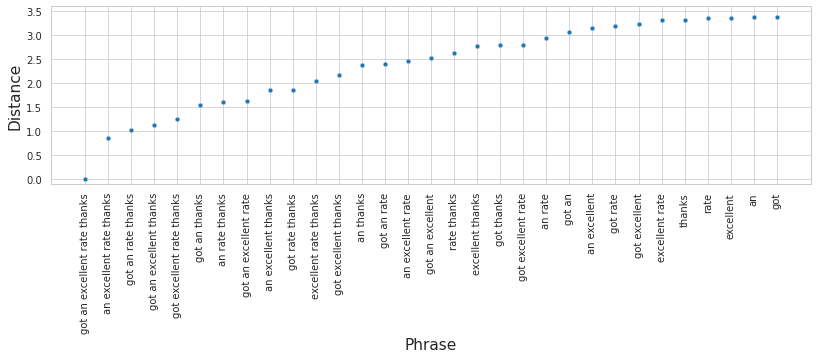

In [31]:
import seaborn as sns
import matplotlib.pyplot as plt
plt.rcParams["figure.figsize"] = (12,3.5)

sns.set_style('whitegrid')
sns.set_context('paper', font_scale=1.6)
# sns.set_context('paper', font_scale=1.68,  rc={"lines.linewidth": 2.2})


sns.scatterplot(data=df, x='Phrase', y='Distance')
plt.tight_layout()
plt.xticks(rotation=90)
plt.ylim(-0.1, 3.6)
plt.tick_params(axis='both', which='major', labelsize=10)
plt.savefig('perturbate.png', bbox_inches='tight',dpi=300)
